In [1]:
import torch
torch.manual_seed(0)

from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from dataset import LiverDataset

c:\Users\kanno\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CSV_LABELS = './SeriesClassificationKey.csv'
CSV_LABELS_TYPE = './SequenceTypes.csv'
ROOT_DIR = './Series_Classification'

# Total 113.258
TRAIN_P = 90000
VAL_P = 8258
TEST_P = 15000

In [3]:
transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomPerspective(distortion_scale=.1, p=.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1380], std=[0.1735])
])

In [4]:
dataset = LiverDataset(csv_labels=CSV_LABELS, csv_labels_type=CSV_LABELS_TYPE, root_dir=ROOT_DIR, transform=transformer)

In [5]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset=dataset, lengths=[TRAIN_P, VAL_P, TEST_P])

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, pin_memory=True, shuffle=True)

In [7]:
class NET(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=14*14*512, out_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.2),
            nn.Linear(256, 17)
        )
    
    def forward(self, x):
        x = self.conv_layer(x)
        return self.dense_layer(x)

In [9]:
net = NET()
optimizer = optim.Adam(net.parameters(),  lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net.to(device)
device

device(type='cuda')

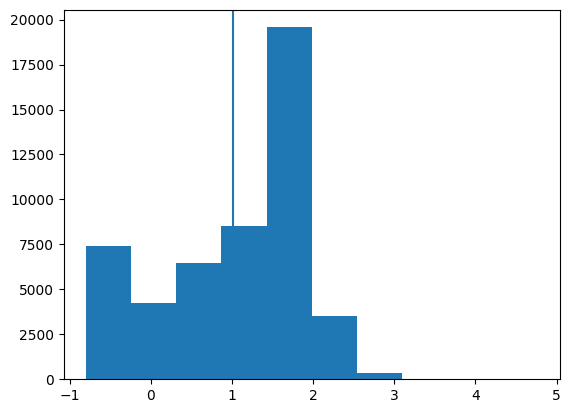

In [22]:
img, y = dataset.__getitem__(2)


# plt.imshow(img.numpy()[0], cmap='gray')
torch.set_printoptions(profile="full")
plt.hist(img[0].flatten())
plt.axvline(img[0].mean())

In [12]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [13]:
error_train, error_test = [], []
accuracy_train, accuracy_test = [], []

In [14]:
def train_model(loader, epoch):
    loop = tqdm(loader)
    running_loss, running_acc = 0, 0

    for (data, targets) in loop:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        y_pred = net(data)
        loss = criterion(y_pred, targets)

        predicted = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
        equals = predicted == targets

        running_acc += torch.mean(equals.float()).item()
        running_loss += loss.item()
 

        loss.backward()
        optimizer.step()

        loop.set_postfix(epoch=epoch, loss=running_loss/len(loader), acc=running_acc/len(loader), mode=net.training)
        

    torch.save(net.state_dict(), f'./weights/ep{epoch}.pth.tar')

    if net.training:
        error_train.append(running_loss/len(loader))
        accuracy_train.append((running_acc/len(loader)))
    else:
        error_test.append(running_loss/len(loader))
        accuracy_test.append((running_acc/len(loader)))

In [15]:
net.train()
for epoch in range(20):
    train_model(train_loader, epoch)
    net.eval()
    train_model(test_loader, epoch)
    net.train()

100%|██████████| 2813/2813 [1:30:09<00:00,  1.92s/it, acc=0.771, epoch=0, loss=0.65, mode=1]   


100%|██████████| 469/469 [14:56<00:00,  1.91s/it, acc=0.874, epoch=0, loss=0.325, mode=0]   


100%|██████████| 2813/2813 [1:30:05<00:00,  1.92s/it, acc=0.884, epoch=1, loss=0.309, mode=1]   


100%|██████████| 469/469 [14:55<00:00,  1.91s/it, acc=0.922, epoch=1, loss=0.203, mode=0]   


100%|██████████| 2813/2813 [1:30:04<00:00,  1.92s/it, acc=0.916, epoch=2, loss=0.222, mode=1]   


100%|██████████| 469/469 [14:55<00:00,  1.91s/it, acc=0.94, epoch=2, loss=0.159, mode=0]    


100%|██████████| 2813/2813 [1:30:05<00:00,  1.92s/it, acc=0.933, epoch=3, loss=0.175, mode=1]   


100%|██████████| 469/469 [14:55<00:00,  1.91s/it, acc=0.949, epoch=3, loss=0.135, mode=0]   


100%|██████████| 2813/2813 [1:30:05<00:00,  1.92s/it, acc=0.944, epoch=4, loss=0.149, mode=1]   


100%|██████████| 469/469 [14:56<00:00,  1.91s/it, acc=0.96, epoch=4, loss=0.107, mode=0]    


100%|██████████| 2813/2813 [1:39:56<00:00,  2.13s/it, acc=0.952, epoch=5, loss=0.13, mode=1]    


100%|██████████| 469/469 [16:59<00:00,  2.17s/it, acc=0.965, epoch=5, loss=0.0927, mode=0]  


100%|██████████| 2813/2813 [1:55:37<00:00,  2.47s/it, acc=0.958, epoch=6, loss=0.114, mode=1]   


100%|██████████| 469/469 [19:52<00:00,  2.54s/it, acc=0.967, epoch=6, loss=0.0876, mode=0]  


100%|██████████| 2813/2813 [2:21:23<00:00,  3.02s/it, acc=0.96, epoch=7, loss=0.104, mode=1]     


100%|██████████| 469/469 [16:52<00:00,  2.16s/it, acc=0.97, epoch=7, loss=0.0751, mode=0]   


100%|██████████| 2813/2813 [1:48:42<00:00,  2.32s/it, acc=0.965, epoch=8, loss=0.095, mode=1]   


100%|██████████| 469/469 [19:09<00:00,  2.45s/it, acc=0.974, epoch=8, loss=0.068, mode=0]   


100%|██████████| 2813/2813 [1:59:26<00:00,  2.55s/it, acc=0.966, epoch=9, loss=0.091, mode=1]   


100%|██████████| 469/469 [20:22<00:00,  2.61s/it, acc=0.975, epoch=9, loss=0.0673, mode=0]  


  3%|▎         | 73/2813 [03:06<1:56:27,  2.55s/it, acc=0.0253, epoch=10, loss=0.00202, mode=1]  


KeyboardInterrupt: 

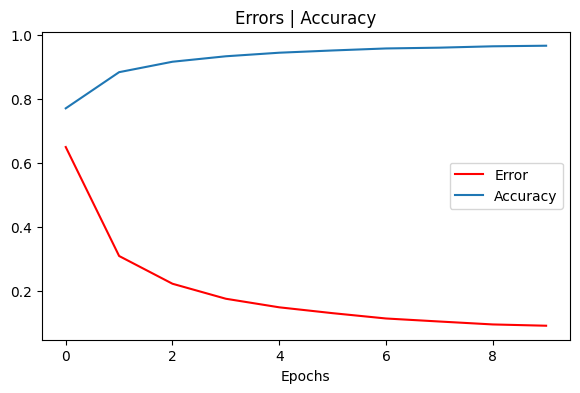

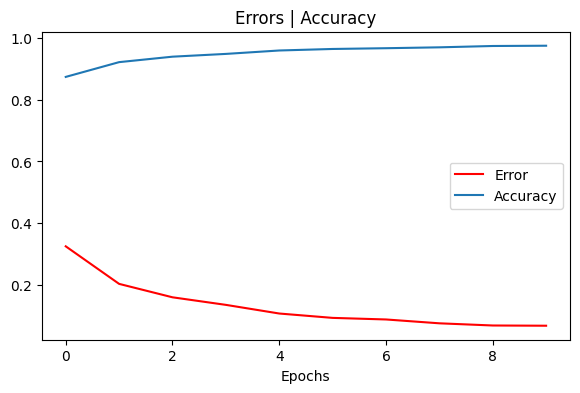

In [16]:
def plotcharts(errors, acc):
    errors = np.array(errors)
    acc = np.array(acc)
    plt.figure(figsize=(15, 4))
    graf01 = plt.subplot(1, 2, 1) # nrows, ncols, index
    graf01.set_title('Errors | Accuracy')
    a = plt.plot(errors, '-', color='red', label='Error')
    plt.xlabel('Epochs')
    plt.setp(a, markersize=5)
    a = plt.plot(acc, '-', label='Accuracy')
    plt.setp(a, markersize=5)
    plt.legend(loc=5)
    plt.show()

plotcharts(error_train, accuracy_train)
plotcharts(error_test, accuracy_test)

In [ ]:
model_trained = NET()
model_trained.load_state_dict(torch.load('weights/ep9.pth.tar'))
model_trained.eval()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_trained.to(device)

In [10]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)

In [11]:
running_acc = 0
wrongs_pred  = []

for (data, targets) in (loop := tqdm(val_loader)):
    data, targets = data.to(device), targets.to(device)

    y_pred = model_trained(data)

    y_pred = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
    equals = y_pred == targets

    running_acc += torch.mean(equals.float()).item()

    for i in range(len(data)):
        if y_pred[i] != targets[i]:
            wrongs_pred.append((y_pred[i].item(), targets[i].item()))

    loop.set_postfix(running_acc=running_acc/len(val_loader))

100%|██████████| 259/259 [01:45<00:00,  2.47it/s, running_acc=0.972]


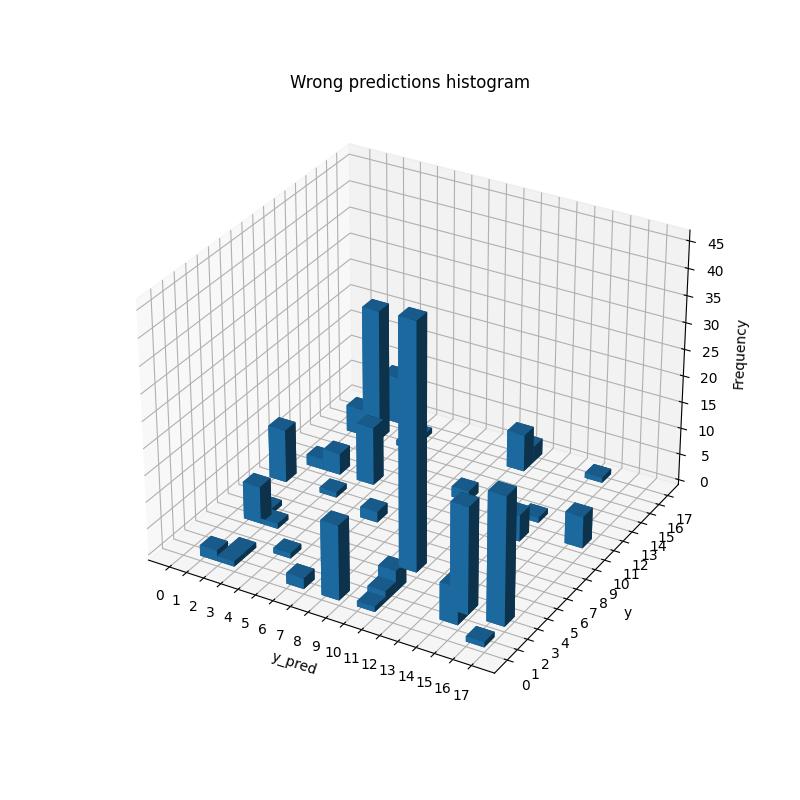

In [79]:
%matplotlib widget

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

pred = set(wrongs_pred)

ax.set_title('Wrong predictions histogram')

major_ticks = np.arange(0, 101, 1)
z_major_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
ax.set_zticks(z_major_ticks)

ax.set_xlabel('y_pred')
ax.set_ylabel('y')
ax.set_zlabel('Frequency')


xpos = [x[0] for x in pred]
ypos = [x[1] for x in pred]

dz = [wrongs_pred.count(x) for x in pred]


ax.bar3d(xpos, ypos, 0, 1, 1, dz)
plt.show()

In [84]:
def ValidateModel():
    model_trained.eval()

    data, targets = next(iter(val_loader))

    data, targets = data.to(device), targets.to(device)

    y_pred = model_trained(data)
    y_pred = torch.argmax(F.softmax(y_pred, dim=1), dim=1)

    images = data.permute(0, 2, 3, 1).cpu().numpy()

    ncolumn, nrow = 4, 8
    _, ax = plt.subplots(ncolumn, nrow, figsize=(22, 9))
    
    i = 0
    for row in range(ncolumn):
        ax_row = ax[row]
        for column in range(nrow):
            ax_column = ax_row[column]
            ax_column.imshow(images[i])
            ax_column.set_xticklabels([])
            ax_column.set_yticklabels([])
            col = 'blue' if y_pred[i] == targets[i] else 'red'
            ax_column.set_title(y_pred[i].item(), color=col)
            i += 1

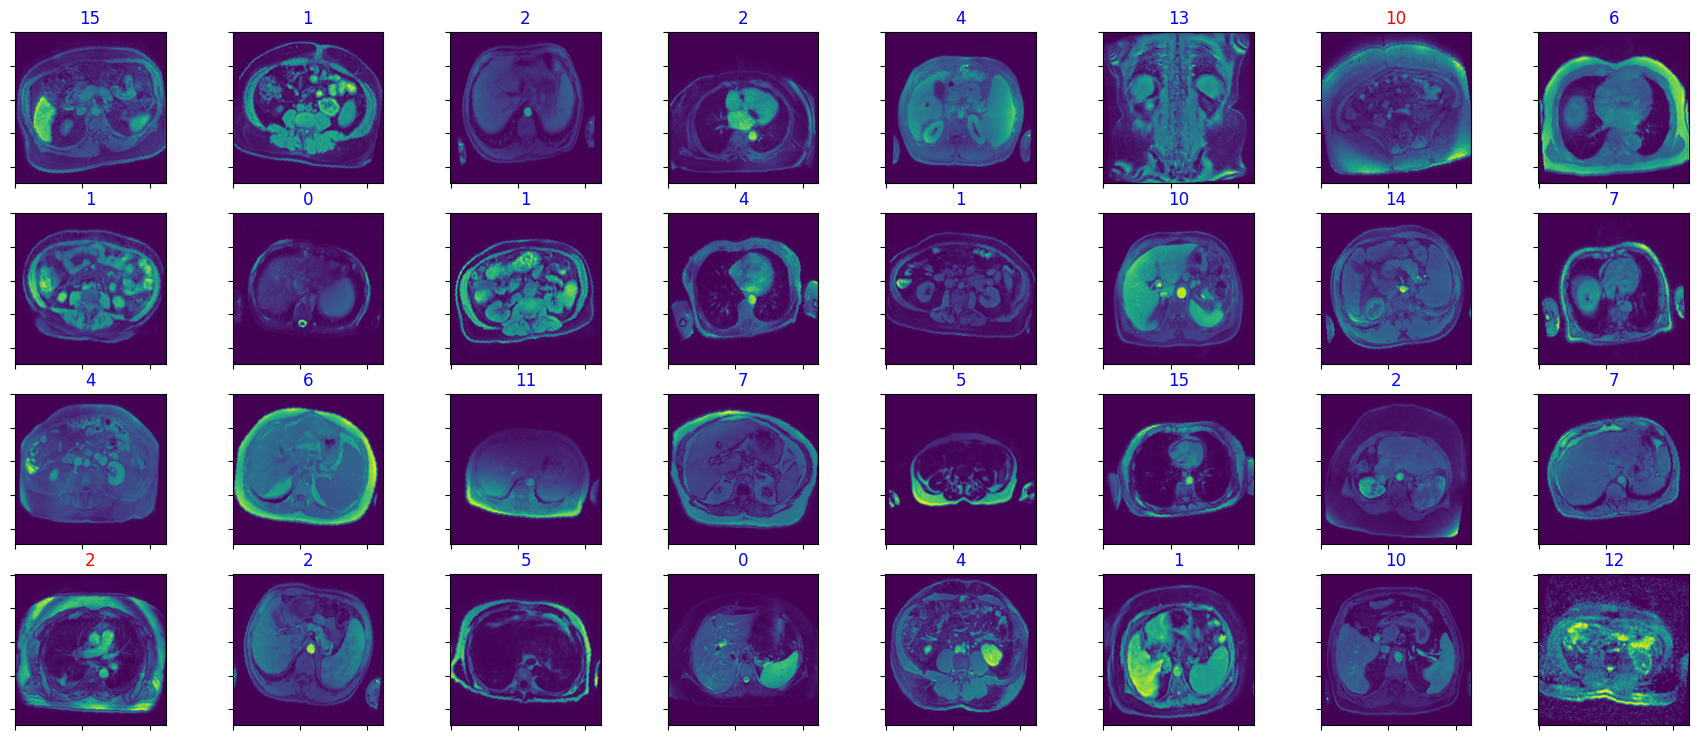

In [89]:
ValidateModel()